# Homework 3 - Unsupervised Learning
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

N = 200 # Number of samples

def generate_gaussian_components(N):
    m_1 = [0, 0]
    C_1 = [[2, 0], [0, 1]]
    m_2 = [-2, 1]
    C_2 = [[9.0/8, 7.0/8], [7.0/8, 9.0/8]]
    m_3 = [3, 2]
    C_3 = [[2, 1], [1, 2]]
    
    pi_1 = 1.0/2
    pi_2 = 1.0/6
    
    x = np.zeros((N, 2))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            #print(1)
            x[i, :] = np.random.multivariate_normal(m_1, C_1, 1)
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            #print(2)
            x[i, :] = np.random.multivariate_normal(m_2, C_2, 1)
            z[i][1] = 1
        else:
            #print(3)
            x[i, :] = np.random.multivariate_normal(m_3, C_3, 1)
            z[i][2] = 1
    return x, z

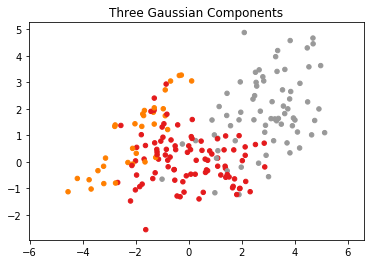

In [2]:
# Three Gaussian components, N samples
x, z = generate_gaussian_components(N)
plt.scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
plt.axis('equal')
plt.title("Three Gaussian Components")
plt.show()

# 1) Implementation of K-means algorithm

In [3]:
def k_means(N, K, C, x):
    m = np.zeros((K, np.size(x, 1)))
    C_new = np.zeros((N, 1))
    while True:
        for j in range(K):
            C_abs = 0
            for i in range(N):
                if C[i] == j+1:
                    C_abs += 1
                    m[j] += x[i]
            if C_abs == 0:
                C_abs = 1
            m[j] /= C_abs
        
        for i in range(N):
            min_distance = math.inf
            for j in range(K):
                distance = np.linalg.norm(x[i] - m[j])
                if distance < min_distance:
                    C_new[i] = j+1
                    min_distance = distance
        
        # Check for convergence
        if np.all(C_new == C):
            return m, C_new
        
        C = C_new
        
def mean_squared_error(x, m, C):
    N = len(x)
    K = len(m)
    smse = np.zeros((K,1))
    for i in range(N):
        j = int(C[i])
        smse[j-1] += np.linalg.norm(x[i] - m[j-1])
    return np.sum(smse) / N

In [4]:
n_random_initializations = 5
K_max = 5

m_optimal = np.zeros((K_max, 2, K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

#print("C_optimal: ", C_optimal)
#print("m_optimal: ", m_optimal)

K-means complete


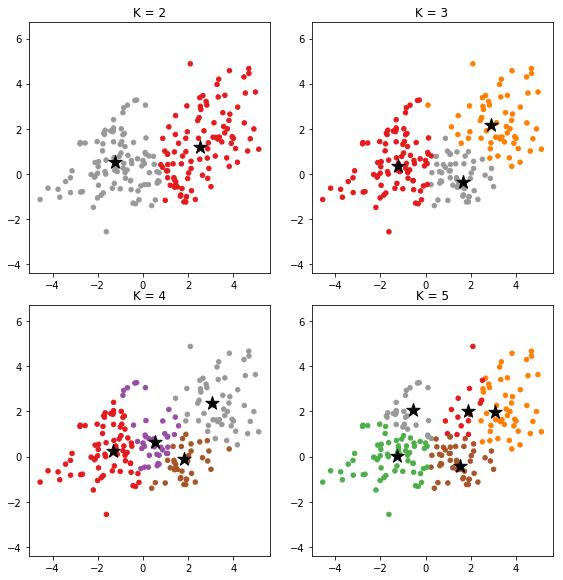

In [5]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].scatter(m_optimal[0:K, :, K-1][:, 0], m_optimal[0:K, :, K-1][:, 1], marker='*', s=200, c='#050505')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [6]:
def empirical_probabilities():
    empirical_probabilities = np.zeros((3, K_max, K_max))
    for K in range(2, K_max+1):
        for li in range(3):
            for j in range(K):
                num_a = 0
                num_z = 0
                for i in range(N):
                    if z[i, li] == 1:
                        num_z += 1
                        if a[i, j, K-1] == 1:
                            num_a += 1
                empirical_probabilities[li, j, K-1] = num_a / num_z
    return empirical_probabilities

def print_ep(z, a):
    ep = empirical_probabilities()
    print("Empirical Probabilities:")
    for i in range(1, K_max):
        print("{}-means:".format(i+1))
        print("\tz = {}\tz = {}\tz = {}".format(1, 2, 3))
        for j in range(i+1):
            print("a = {0}\t{1:.2f}\t{2:.2f}\t{3:.2f}".format(j+1, ep[0, j, i], ep[1, j, i], ep[2, j, i]))
            #print("a = {}\t{}\t{}\t{}".format(j+1, ep[0, j, i], ep[1, j, i], ep[2, j, i]))
        print()
        
print_ep(z, a)

print(empirical_probabilities())

Empirical Probabilities:
2-means:
	z = 1	z = 2	z = 3
a = 1	0.32	0.00	0.96
a = 2	0.68	1.00	0.04

3-means:
	z = 1	z = 2	z = 3
a = 1	0.57	0.97	0.04
a = 2	0.01	0.03	0.78
a = 3	0.42	0.00	0.18

4-means:
	z = 1	z = 2	z = 3
a = 1	0.46	0.85	0.01
a = 2	0.25	0.15	0.14
a = 3	0.28	0.00	0.12
a = 4	0.00	0.00	0.72

5-means:
	z = 1	z = 2	z = 3
a = 1	0.02	0.00	0.18
a = 2	0.45	0.58	0.03
a = 3	0.02	0.00	0.62
a = 4	0.39	0.00	0.15
a = 5	0.12	0.42	0.01

[[[0.         0.31578947 0.56842105 0.46315789 0.02105263]
  [0.         0.68421053 0.01052632 0.25263158 0.45263158]
  [0.         0.         0.42105263 0.28421053 0.02105263]
  [0.         0.         0.         0.         0.38947368]
  [0.         0.         0.         0.         0.11578947]]

 [[0.         0.         0.96969697 0.84848485 0.        ]
  [0.         1.         0.03030303 0.15151515 0.57575758]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.     

Read the table above as for each _true_ class (e.g. 3), if K is e.g. 2, the conditional probabilities for each assigned class are printed in the second column in the third 2D table.

# 2) Implementation of EM algorithm

In [7]:
from scipy.stats import multivariate_normal

def EM(m, C, pi, N, K, x, max_iter=10):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k
        
m_EM = np.zeros((K_max, 2, K_max))
C_EM = np.zeros((K_max, K_max, 2, 2))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(2)[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)

print("EM complete")

EM complete


In [8]:
p_k_average = np.zeros((3, K_max, K_max))
for K in range(2, K_max+1):
    for li in range(3):
        for j in range(K):
            n = 0
            for i in range(N):
                if z[i, li] == 1:
                    p_k_average[li, j, K-1] += p_k_EM[j-1, i, K-1]
                    n += 1
            p_k_average[li, j, K-1] /= n

print(p_k_average)

[[[0.00000000e+00 4.17975356e-01 2.13520337e-02 3.62068834e-01
   1.40025640e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 5.13655527e-01 2.38851572e-05 1.24911002e-03
   4.83207132e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 5.87864373e-02 5.61929292e-01 1.27513794e-01
   7.74273474e-04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.0000000

# 3) Geometrically find visualization of means and covariances as a contour plot

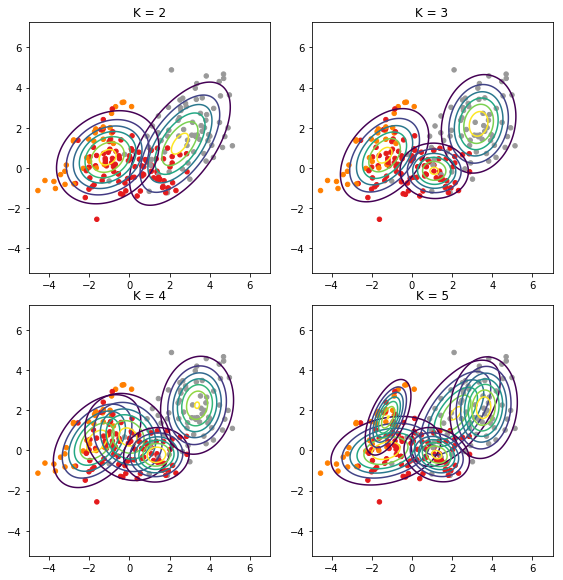

In [9]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

X = np.linspace(-5, 7, N)
Y = np.linspace(-5, 7, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
    for j in range(K):
        Z = multivariate_gaussian(pos, m_EM[j,:,K-1], C_EM[K-1, j])
        axes[row, col].contour(X, Y, Z)
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

We see that for $K = 3$, the means and covariances found from k-means and EM follow the data nicely, as the contour plots above is very similar to contour plots that could be generated with the actual means and covariances.

Further experiments will be done with higher dimensional data
# 4) Generate a random vector $\mathbf{u}$ in $d$ dimensions

In [10]:
d = 30

def generate_random_vector(d):
    u = np.zeros((d, 1)) 
    P_1 = 2.0/3
    P_2 = 1.0/6
    for i in range(d):
        a = random.uniform(0, 1)
        if (a < P_1):
            u[i] = 0
        elif (a < P_1 + P_2):
            u[i] = 1
        else:
            u[i] = -1
    return u

u = np.zeros((d, 6))
for j in range(6):
    u[:,j] = generate_random_vector(d).T
print(u)

[[ 0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.]
 [ 1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  1. -1.  0.]
 [ 1.  0. -1.  0.  0.  0.]
 [ 1.  1.  0.  0.  0. -1.]
 [ 0.  0. -1.  0.  1.  1.]
 [ 0.  0.  0.  0. -1. -1.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [ 1.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0. -1.  0. -1.  0.]
 [ 1. -1.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.]
 [ 1.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  0.  1. -1.]
 [-1. -1.  1.  0.  0.  0.]
 [-1. -1.  0.  0.  1.  0.]
 [ 1.  1.  0. -1.  0.  0.]]


The vectors above are manually inspected to see that the vectors u_j, j=1,...,7 are quasi-orthogonal.
If not, the vectors are regenerated.

# 5) Generate $d$-dimensional  data samples for a Gaussian mixture distribution with 3 equiprobable components

In [11]:
def generate_d_dimensional_gaussian_components(N, d, u):

    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5] + noise
            z[i][1] = 1
        else:
            x[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4] + noise
            z[i][2] = 1
    return x, z

# 6) Generate N data samples from the preceding model, and classify with k-means

In [12]:
N = 200
x, z = generate_d_dimensional_gaussian_components(N, d, u)

In [14]:
m_optimal = np.zeros((K_max, np.size(x, 1), K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

print(m_optimal.shape)

K-means complete
(5, 30, 5)


In [14]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1
        
#print(a)

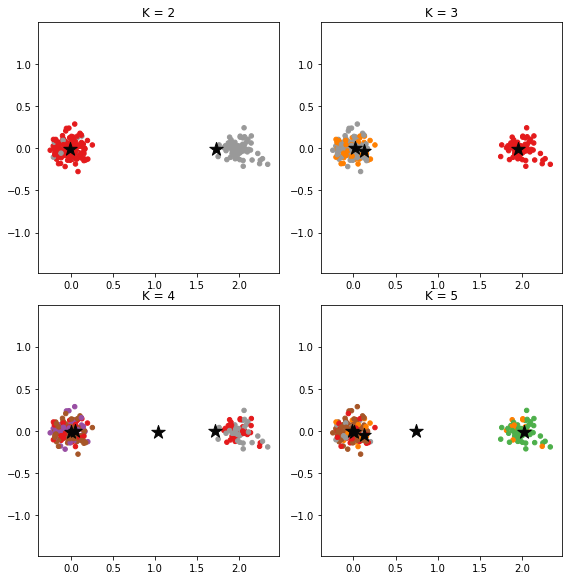

In [15]:
# To get a general idea of how the data is distributed,
# it is plotted in 2D
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].scatter(m_optimal[0:K, :, K-1][:, 0], m_optimal[0:K, :, K-1][:, 1], marker='*', s=200, c='#050505')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [16]:
print(empirical_probabilities())

[[[0.         1.         0.         0.         0.5       ]
  [0.         0.         0.24285714 0.         0.        ]
  [0.         0.         0.75714286 1.         0.        ]
  [0.         0.         0.         0.         0.5       ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.         1.         0.47058824 0.        ]
  [0.         1.         0.         0.         0.79411765]
  [0.         0.         0.         0.         0.20588235]
  [0.         0.         0.         0.52941176 0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.82258065 0.         0.4516129  0.        ]
  [0.         0.17741935 0.53225806 0.5483871  0.        ]
  [0.         0.         0.46774194 0.         0.27419355]
  [0.         0.         0.         0.         0.51612903]
  [0.         0.         0.         0.         0.20967742]]]


The probabilities above should be read in the same way as for k-means with two-dimensional data.

# 7) Geometric insight into how the cluster centers found by *K*-means relate to the vectors ${\mathbf{\{u\}}_j}$ in the model

For K = 3, the optimal cluster centers should be close to the sum of the $\mathbf{u}_j$, where $j$ is in the set as given by the equations in problem 6).

# 8) *d*-dimensional EM

In [17]:
def EM(m, C, pi, N, K, x, max_iter=100):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k

m_EM = np.zeros((K_max, d, K_max))
C_EM = np.zeros((K_max, K_max, d, d))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(np.size(x, 1))[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    #m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)
    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x, max_iter = 2)
    
print("EM complete")

EM complete


In [18]:
for K in range(1, K_max):
    w, v = np.linalg.eig(C_EM[K])
    #print("K =", K+1)
    #print(v)

The eigenvectors of the covariance matrices are very similar to those of the parameters of the Gaussian mixture model.

# 9) Deterministic annealing
Implementation:
- Initialization
- Cooling
- Check for termination
- Quenching

In [19]:
# Three Gaussian components, N samples
N = 20
x, z = generate_gaussian_components(N)

In [20]:
#Initialization
m = 1/N * np.sum(x, axis=0)

# Cooling
alpha = 0.5
m_1 = m
m_2 = m + np.random.rand()

# Run soft K-means until convergence

# Check for termination

# Quenching